## Limpieza del dataset

In [214]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np


In [215]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [216]:
data_raw = pd.read_csv(r'..\data\data_raw.csv', parse_dates=True)

In [217]:
data_raw.columns

Index(['date', 'ticker', 'year_x', 'trade_date', 'close_reb_adj', 'vol_1y',
       'max_1y', 'min_1y', 'sma_1y', 'sma_2y', 'volatility_1y', 'None',
       'report_date', 'financial_year_end_date', 'revenue', 'eps', 'ebitda',
       'netinc', 'roe', 'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit',
       'currentratio', 'capex', 'ncfo', 'equity', 'de', 'year_y',
       'rebalance_date', 'closeadj', 'ret_6m', 'ret_12m', 'target_12m_shift',
       'next_exit_date', 'target_12m_final', 'index', 'risk_free_rate',
       'sharpe_1y'],
      dtype='object')

In [218]:
print("Shape del dataset:", data_raw.shape)
print("\nPrimeras filas:")
display(data_raw.head())

# Número de tickers y años únicos
n_tickers = data_raw['ticker'].nunique()
years = pd.to_datetime(data_raw['date']).dt.year.unique()
print(f"Número de tickers únicos: {n_tickers}")
print(f"Años cubiertos: {years.min()} - {years.max()} ({len(years)} años)")


Shape del dataset: (14045, 41)

Primeras filas:


,date,ticker,year_x,trade_date,close_reb_adj,vol_1y,max_1y,min_1y,sma_1y,sma_2y,volatility_1y,None,report_date,financial_year_end_date,revenue,eps,ebitda,netinc,roe,evebitda,fcfps,pb,pe,marketcap,ebit,currentratio,capex,ncfo,equity,de,year_y,rebalance_date,closeadj,ret_6m,ret_12m,target_12m_shift,next_exit_date,target_12m_final,index,risk_free_rate,sharpe_1y
0,1998-03-31,GWW,1998.0,1998-03-31,32.910,11078200.0,32.974,29.972,31.460607,31.460607,0.197283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-03-31,32.910,NaN,NaN,-0.151200,NaN,-0.151200,0,5.6555,-1.053084
1,1998-03-31,FCN1,1998.0,1998-03-31,87.697,54968300.0,90.603,71.356,79.785016,79.785016,0.246504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-03-31,87.697,NaN,NaN,NaN,1998-10-02,-0.268789,0,5.6555,-1.319834
2,1998-03-31,FCX,1998.0,1998-03-31,5.788,91016200.0,5.933,3.901,4.454377,4.454377,0.463852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-03-31,5.788,NaN,NaN,-0.448860,NaN,-0.448860,0,5.6555,-1.089604
3,1998-03-31,HRB,1998.0,1998-03-31,5.144,84888000.0,5.273,4.323,4.849443,4.849443,0.268575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-03-31,5.144,NaN,NaN,0.017691,2020-09-21,0.017691,0,5.6555,-0.144706
4,1998-03-31,SIAL,1998.0,1998-03-31,15.580,54066200.0,17.848,15.397,16.437180,16.437180,0.345806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-03-31,15.580,NaN,NaN,-0.207125,2015-11-18,-0.207125,0,5.6555,-0.762508


Número de tickers únicos: 1132
Años cubiertos: 1998 - 2025 (28 años)


##### Columnas a mantener. Elimninamos columnas repetidas, fechas, precios, etc. Dejamos ticker ya que posteriormente haremos fill de nan's agrupando por ticker pero finalmente se eliminará para no dejar al modelo reconocer una misma empresa a lo largo del tiempo.

In [219]:
data_clean = data_raw[['ticker','date','vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y', 'volatility_1y', 
       'revenue', 'eps', 'ebitda','netinc', 'roe', 'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 
       'ebit','currentratio', 'capex', 'ncfo', 'equity', 'de',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate','target_12m_final', 'sharpe_1y']
]

##### Análisis de Datos Faltanates: 

La Figura 1 muestra la matriz de valores faltantes. Se observa que la mayor parte de las variables presenta un nivel de completitud elevado, con datos ausentes localizados principalmente en current ratio. Además se observa que para la primera ventana (1998) no hay datos fundamentales ya que no se puedo usar los datos del año fiscal 1997. Tampoco de momentum dada la necesidad de una base comparable.

La Figura 2 representa la correlación de ausencia de datos entre variables. Destaca que los faltantes en variables fundamentales están altamente correlacionados: cuando una de ellas no está disponible para una observación, las demás suelen estar ausentes también, reflejando la no disponibilidad de información financiera para esa empresa en ese año. Por el contrario, las variables técnicas y de precios rara vez presentan datos faltantes y su completitud no depende de la de los fundamentales.


<Figure size 4600x1800 with 0 Axes>

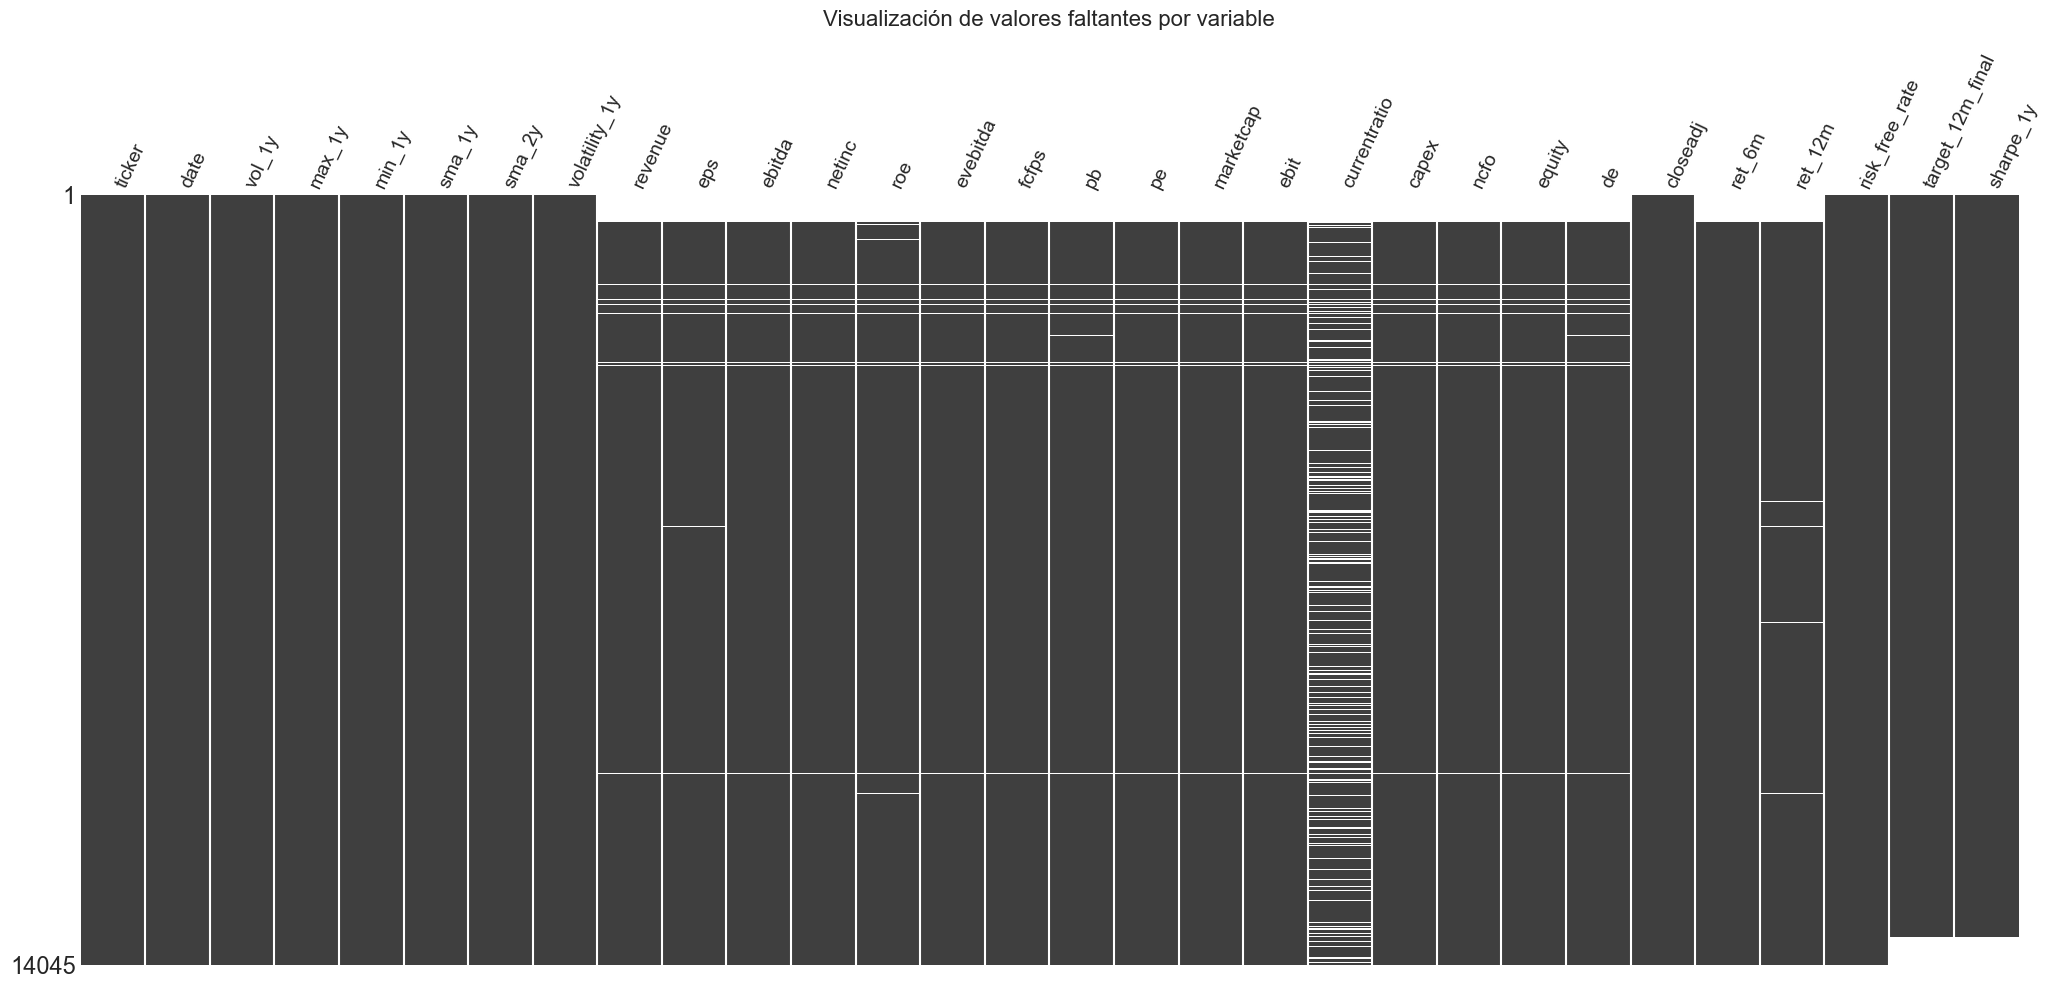

<Figure size 1400x1200 with 0 Axes>

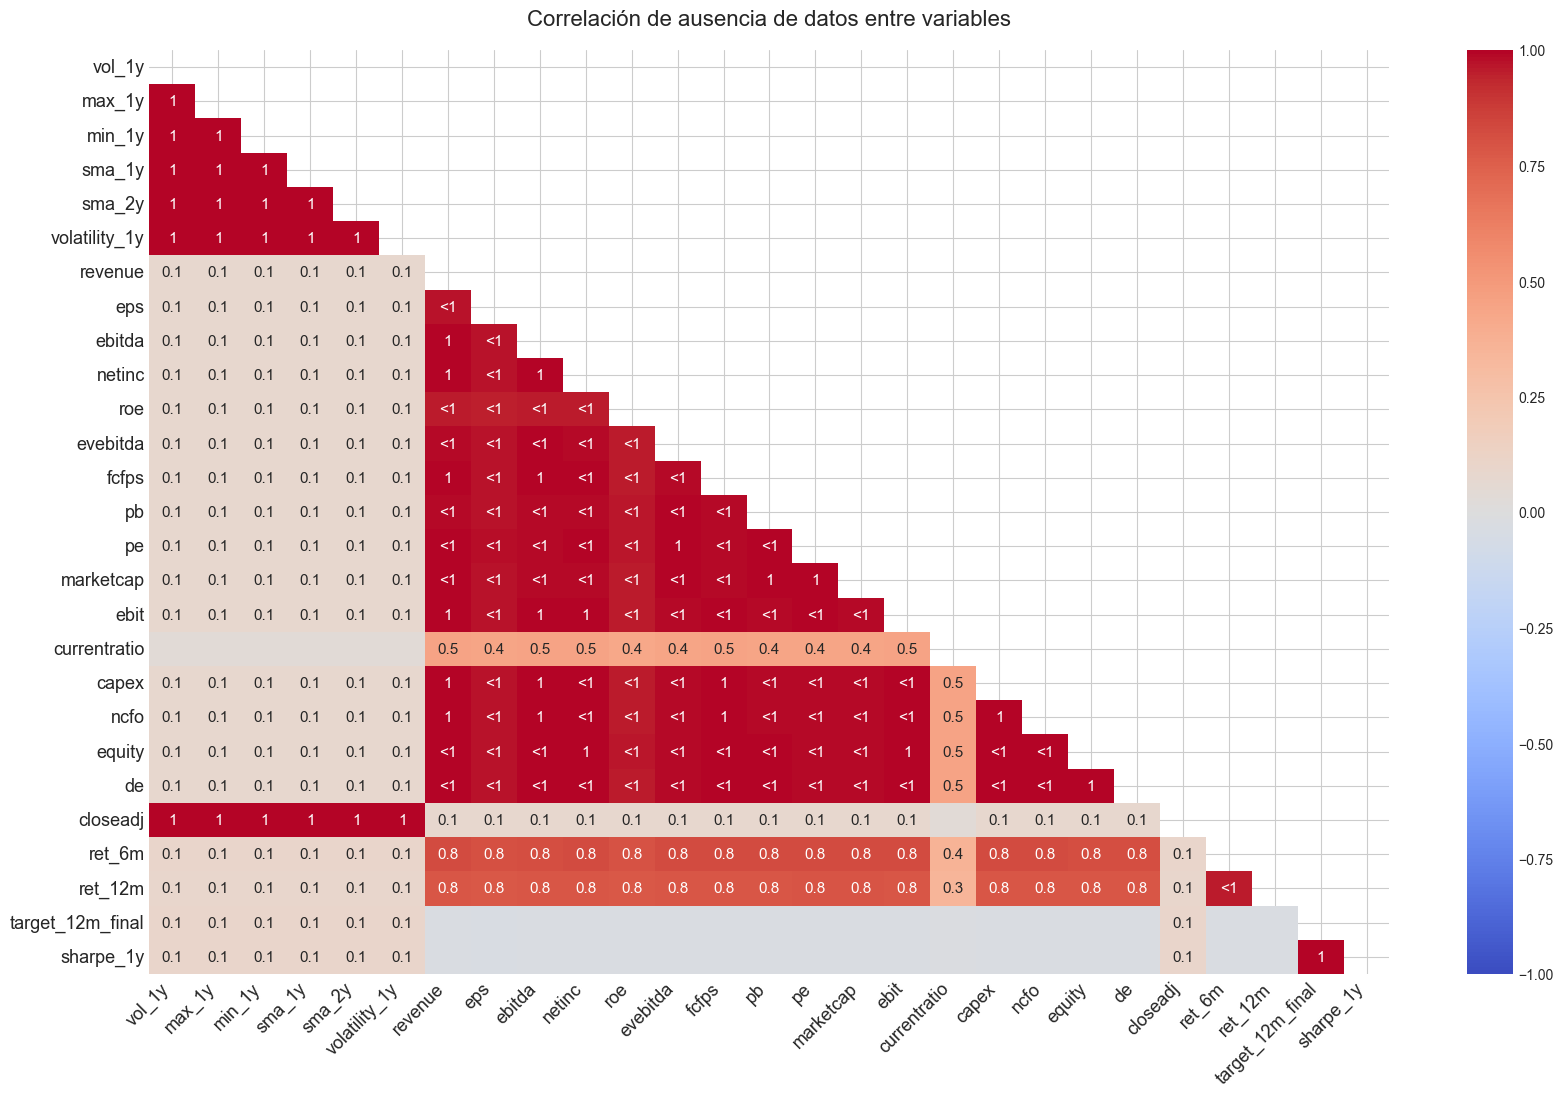

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_4268\4044414108.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nan_percent.index, y=nan_percent.values, palette='Blues_r')


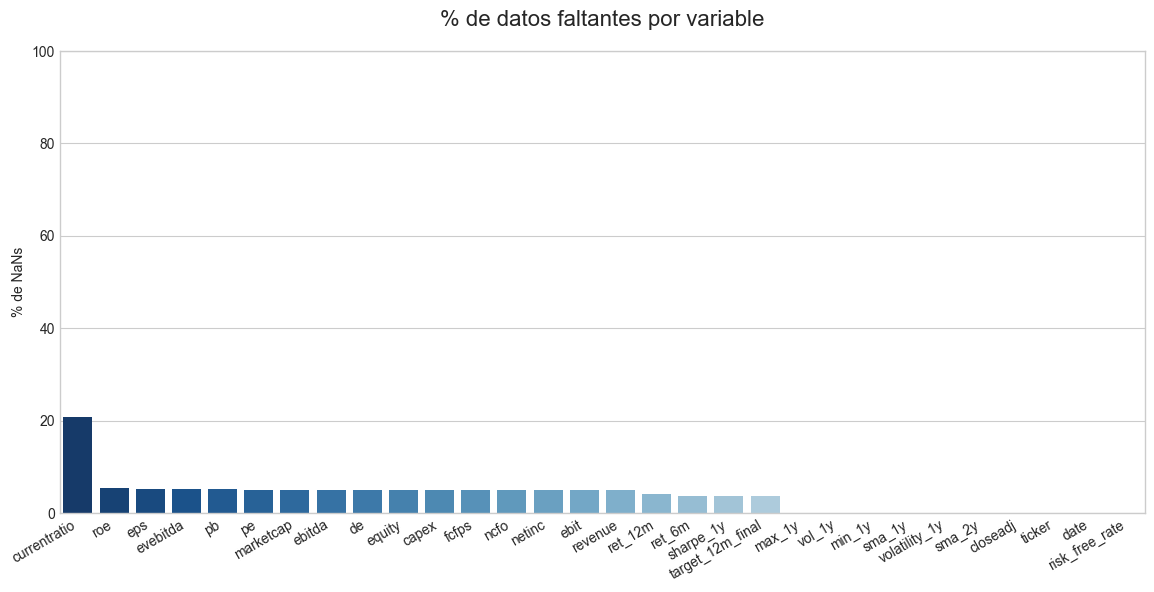

,currentratio,roe,eps,evebitda,pb,pe,marketcap,ebitda,de,equity,capex,fcfps,ncfo,netinc,ebit,revenue,ret_12m,ret_6m,sharpe_1y,target_12m_final,max_1y,vol_1y,min_1y,sma_1y,volatility_1y,sma_2y,closeadj,ticker,date,risk_free_rate
n_faltantes,2929,761,736,717,715,712,709,708,707,706,705,705,705,704,704,703,580,530,507,507,5,5,5,5,5,5,5,0,0,0


In [220]:

# Estilo y fuentes para gráficos más bonitos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 10, 
    'axes.titlesize': 16, 
    'axes.labelsize': 10,
    'axes.titlepad': 18
})

# 1. Matrix de valores faltantes
plt.figure(figsize=(46,18))
msno.matrix(data_clean, fontsize=14, sparkline=False, width_ratios=(0.95, 0.05))
plt.title("Visualización de valores faltantes por variable")
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=65, ha='left')
plt.show()

# 2. Heatmap de correlación de ausencia de datos
plt.figure(figsize=(14,12))
msno.heatmap(data_clean, cmap="coolwarm", fontsize=13)
plt.title("Correlación de ausencia de datos entre variables")
plt.show()

# 3. Barplot de % de datos faltantes por columna
nan_percent = data_clean.isnull().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(14,6))
sns.barplot(x=nan_percent.index, y=nan_percent.values, palette='Blues_r')
plt.title('% de datos faltantes por variable')
plt.ylabel('% de NaNs')
plt.xlabel('')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 100)
plt.show()

# 4. Tabla rápida de NaNs para tu memoria
display(data_clean.isnull().sum().sort_values(ascending=False).to_frame('n_faltantes').T)


##### Eliminamos La primera y la última ventana ya que 1998 aún no tiene datos fundamentales (se usarían los datos de Año Fiscal 1997 que no se extrajeron) y 2025 no tiene variable de target completada ya que se desconocen los retornos a fecha de hoy 29/05/2025

In [221]:
data_clean = data_clean[data_clean['date'] != "1998-03-31"]
data_clean = data_clean[data_clean['date'] != "2025-03-31"]

##### Eliminamos filas con un porcentaje de NaN's superior al 70%

In [223]:
missing_threshold = int(data_clean.shape[1] * 0.7)
data_clean = data_clean[data_clean.isnull().sum(axis=1) <= missing_threshold]


##### Parece que sigue habiendo filas para las cuales no se puedo recuperar datos fundamentales. Además current ratio presenta un alto número de valores faltantes

In [227]:
data_clean.isna().sum()

ticker                0
date                  0
vol_1y                0
max_1y                0
min_1y                0
sma_1y                0
sma_2y                0
volatility_1y         0
revenue             195
eps                 222
ebitda              198
netinc              196
roe                 244
evebitda            206
fcfps               196
pb                  205
pe                  204
marketcap           202
ebit                196
capex               196
ncfo                196
equity              197
de                  197
closeadj              0
ret_6m               26
ret_12m              73
risk_free_rate        0
target_12m_final      0
sharpe_1y             0
dtype: int64

### Se decide eliminar la columna dado su impacto limitado 

In [225]:
data_clean = data_clean.drop(columns=['currentratio'])

### Para el resto de columnas, en caso de que el valor faltante no ocurra en la primera aparición de la empresa, se realiza un forward fill tomando el dato disponible inmediatamente anterior 

In [226]:
data_clean = data_clean.groupby('ticker').apply(lambda g: g.fillna(method='ffill')).reset_index(drop=True)



C:\Users\Ignacio\AppData\Local\Temp\ipykernel_4268\124016390.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = data_clean.groupby('ticker').apply(lambda g: g.fillna(method='ffill')).reset_index(drop=True)
C:\Users\Ignacio\AppData\Local\Temp\ipykernel_4268\124016390.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_clean = data_clean.groupby('ticker').apply(lambda g: g.fillna(method='ffill')).reset_index(drop=True)


#### Para las filas de aún con valores faltantes simplemente eliminamos ya que no podemos inventarnos datos fundamentales y no tiene sentido promediar con datos futuros (look ahead bias) o con datos de empresas en el mismo año.

In [228]:
data_clean = data_clean.dropna()


In [229]:
data_clean.to_csv(r'..\data\data_clean.csv', index=False)

In [230]:
len(data_clean)

12721